In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
import time
import wandb
import julia
from julia import DynamicalSystems
from julia import Base
from julia import Main

%load_ext julia.magic

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Initializing Julia interpreter. This may take some time...


## given $\textbf{p}, \textbf{q} \in \mathbb{R}^{d}$ 

### $$\begin{equation}
\begin{aligned}
    \text{linear_module_up } : \mathcal{L}^{up}\begin{pmatrix}
    \textbf{p} \\
    \textbf{q}
    \end{pmatrix} &= \begin{pmatrix}
    I & S\\
    0 & I
    \end{pmatrix} \begin{pmatrix}
    \textbf{p} \\
    \textbf{q}
    \end{pmatrix} \\
    \text{linear_module_low } : \mathcal{L}^{low}\begin{pmatrix}
    \textbf{p} \\
    \textbf{q}
    \end{pmatrix} &= \begin{pmatrix}
    I & 0\\
    S & I
    \end{pmatrix} \begin{pmatrix}
    \textbf{p} \\
    \textbf{q}
    \end{pmatrix},
\end{aligned}
\end{equation}
$$

## where $S \in \mathbb{R}^{d \times d}$ is symmetric.

### $$\begin{equation}
\begin{aligned}
    \text{activation_module_up } : \mathcal{N}^{up}\begin{pmatrix}
    \textbf{p} \\
    \textbf{q}
    \end{pmatrix} &= \begin{bmatrix}
    I & \sigma_{\textbf{a}}\\
    0 & I
    \end{bmatrix} \begin{pmatrix}
    \textbf{p} \\
    \textbf{q}
    \end{pmatrix} := \begin{pmatrix}
    diag(\textbf{a})\sigma(\textbf{q}) + \textbf{p}\\
    \textbf{q}
    \end{pmatrix}\\
    \text{activation_module_low } : \mathcal{N}^{low}\begin{pmatrix}
    \textbf{p}\\
    \textbf{q}
    \end{pmatrix} &= \begin{bmatrix}
    I & 0 \\
    \sigma_{\textbf{a}} & I
    \end{bmatrix} \begin{pmatrix}
    \textbf{p} \\
    \textbf{q}
    \end{pmatrix} := \begin{pmatrix}
    \textbf{p} \\
    diag(\textbf{a})\sigma(\textbf{p}) + \textbf{q}
    \end{pmatrix},
\end{aligned}
\end{equation}
$$

## where $\sigma$ acts element-wise. The parameters are $S$ and $\textbf{a}$.

In [127]:
class linear_module_up(layers.Layer):
    
    def __init__(self, bias):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(2,2),
        initializer = 'random_normal',
        trainable = True
        )
    
        if bias==1:
            self.b = self.add_weight(
            name='b',
            shape=(4,),
            initializer = 'random_normal',
            trainable = True
            )
            
        else:
            self.b = tf.constant([0., 0., 0., 0.])

    def call(self, x):
        
        L11 = tf.concat([[[1.,0.],[1.,1.]]], 0)
        L12 = self.w + tf.transpose(self.w)
        L21 = tf.concat([[[0.,0.],[0.,0.]]],0)
        L22 = tf.concat([[[1.,0.],[0.,1.]]],0)

        L = tf.concat([tf.concat([L11,L12], 1), tf.concat([L21,L22], 1)], 0)
        
        return tf.linalg.matvec(L,x) + self.b

class linear_module_low(layers.Layer):
    
    def __init__(self, bias):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(2,2),
        initializer = 'random_normal',
        trainable = True
        )

        if bias==1:
            self.b = self.add_weight(
            name='b',
            shape=(4,),
            initializer = 'random_normal',
            trainable = True
            )
            
        else:
            self.b = tf.constant([0., 0., 0., 0.])

    def call(self, x):
        
        L11 = tf.concat([[[1.,0.],[1.,1.]]], 0)
        L12 = tf.concat([[[0.,0.],[0.,0.]]],0) 
        L21 = self.w + tf.transpose(self.w)
        L22 = tf.concat([[[1.,0.],[0.,1.]]],0)

        L = tf.concat([tf.concat([L11,L12], 1), tf.concat([L21,L22], 1)], 0)
        
        return tf.linalg.matvec(L,x) + self.b


class activation_module_up(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(2,),
        initializer = 'random_normal',
        trainable = True
        )


    def call(self, x):        
        t = tf.concat([[[0.,0.,self.w[0], 0.]], [[0.,0.,0., self.w[1]]], [[0.,0.,0.,0.]], [[0.,0.,0.,0.]]], 0)
        
        return x + tf.linalg.matvec(t, tf.math.sigmoid(x))

class activation_module_low(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(2,),
        initializer = 'random_normal',
        trainable = True
        )


    def call(self, x):
        t = tf.concat([[[0.,0.,0.,0.]], [[0.,0.,0.,0.]], [[self.w[0],0.,0.,0.]], [[0.,self.w[1],0.,0.]]],0)
        
        return x + tf.linalg.matvec(t, tf.math.sigmoid(x))

## $$\text{SympNet : } \phi = L_{1} L_{2} \dots L_{5} \text{  } A_{1} \text{  } L_{6} \dots L_{10} \text{  } A_{2} \dots $$

### A bias $\textbf{b} \in \mathbb{R}^{2d}$ is added at the end of every sequence of linear modules as:

## $$\begin{equation}
    \begin{pmatrix}
    I & 0/S_{n}\\
    S_{n}/0 & I
    \end{pmatrix} \dots \begin{pmatrix}
    I & 0 \\
    S_{2} & I
    \end{pmatrix} \begin{pmatrix}
    I & S_{1} \\
    0 & I
    \end{pmatrix} \begin{pmatrix}
    \textbf{q} \\
    \textbf{p}
    \end{pmatrix} + \textbf{b},
\end{equation}
$$

In [6]:
class SympNet(keras.Model):
    
    def __init__(self, N_layers, N_sub):
        
        super().__init__()
        
        
        self.Modules = []
        
        for i in range(N_layers):
            
            if i%2==0:
                self.Modules.append(activation_module_up())
                
            else:
                self.Modules.append(activation_module_low())
                
            for j in range(N_sub):
                
                if j==(N_sub-1):
                    bias = 1
                else:
                    bias = 0
                
                if j%2==0:
                    self.Modules.append(linear_module_up(bias))

                else:
                    self.Modules.append(linear_module_low(bias))
        
        

    def call(self, input_tensor):
        
        boom = self.Modules[0](input_tensor)
        
        for i in range(1,len(self.Modules)):
            boom = self.Modules[i](boom)
    
        return boom

### Training Dataset

In [65]:
%julia T = 10. ; dt = 0.1
%julia ds = DynamicalSystems.Systems.double_pendulum([π/2, 0., 0., 0.5]; G=10.0, L1 = 1.0, L2 = 1.0, M1 = 1.0, M2 = 1.0)
%julia q = DynamicalSystems.Systems.trajectory(ds, T, dt = dt)[:,1];
%julia p = DynamicalSystems.Systems.trajectory(ds, T, dt = dt)[:,2];
%julia qq = DynamicalSystems.Systems.trajectory(ds, T, dt = dt)[:,3];
%julia pp = DynamicalSystems.Systems.trajectory(ds, T, dt = dt)[:,4];

q0 = Main.q.tolist()
q1 = Main.qq.tolist()
p0 = Main.p.tolist()
p1 = Main.pp.tolist()

X = []
for i in zip(p0, p1, q0, q1):
    X.append([[i[0],i[1],i[2],i[3]]])

x_train = np.array(X[:len(X)-1])
x_train = x_train.astype(np.float32)

y_train = np.array(X[1:])
y_train = y_train.astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_dataset = train_dataset.batch(101)

train_dataset.element_spec

(TensorSpec(shape=(None, 1, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 4), dtype=tf.float32, name=None))

# Model + training

### Given a single trajectory in the phase-space 

## $$\mathcal{O}_{true} = \{(\textbf{p}_{i}, \textbf{q}_{i})\}_{i=1}^{N},$$

### the training set is of the form:

## $$ \mathcal{T} = \{ (\textbf{p}_{i}, \textbf{q}_{i}), (\textbf{p}_{i+1}, \textbf{q}_{i+1})\}_{i=1}^{N-1}$$

### The prediction is made by iterating the trained SympNet from a starting point

## $$ \mathcal{O}_{predicted} = \{(\textbf{p}_{0}, \textbf{q}_{0}), \phi(\textbf{p}_{0}, \textbf{q}_{0}), \phi(\phi(\textbf{p}_{0}, \textbf{q}_{0})), \dots \}$$


In [94]:
model = SympNet(10, 5)

In [123]:
#import tensorflow_probability as tfp
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=keras.optimizers.Adam(0.001), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [124]:
#wandb.init()
start_time = time.time()
history = model.fit(train_dataset, epochs=2000, verbose=0)
print("running time : %s seconds" % (time.time() - start_time))

running time : 153.82605814933777 seconds


### Plot the loss

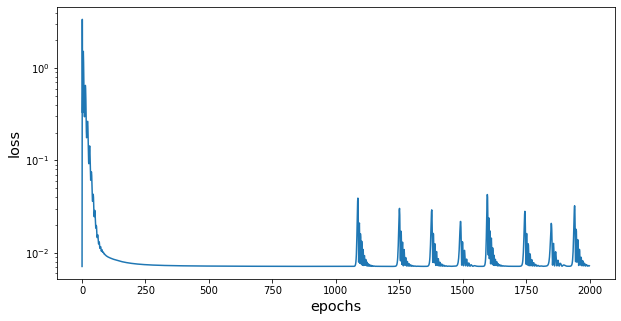

In [125]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"])
plt.xlabel("epochs", fontsize = "x-large")
plt.ylabel("loss", fontsize = "x-large")
plt.yscale("log")

#plt.savefig("DP_loss_adam_bs1_epochs1000_clipping0001")

### Plot the result

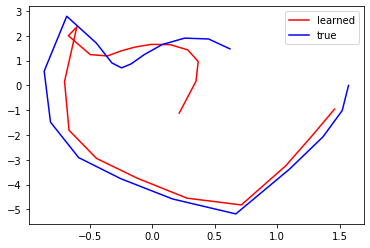

In [126]:
N_test = 20

p = [model(x_train[0][0])[0]]
pp = [model(x_train[0][0])[1]]

q = [model(x_train[0][0])[2]]
qq = [model(x_train[0][0])[3]]

run = [model(X[0][0])]

for i in range(N_test):
    run.append(model(run[-1]))
    p.append(run[-1][0])
    pp.append(run[-1][1])
    q.append(run[-1][2])
    qq.append(run[-1][3])


plt.plot(q, p, color = "r", label = "learned")
plt.plot(q0[:20], p0[:20], color = "b", label = "true")
plt.legend()
plt.show()